# Introduction to Active Learning with Bayesian Optimization

Bayesian Optimization (BO) is frequently based on Gaussian Process regression (GPR), a probabilistic regression tool. GPR is used to fit *the statistically most likely function*, given data. A Gaussian process (GP) had two forms: the **prior** (encoding any prior belief about the function) and the **posterior** (see image below, from [Rasmussen & Williams, MIT Press (2006)](http://www.gaussianprocess.org/gpml/)). Given the GP prior and some data points (observations), the Bayes' rule is used to compute the GP posterior. **GP posterior mean** is statistically the most likely function that fits the data. **GP posterior variance** is the measure of confidence on the GP mean, with high confidence where variance vanishes.

<img src="https://gitlab.com/joalof/bigmax_boss_tutorials/-/raw/319e6ba6dbbf37ac456abc6dac7f4de5ef097312/figures/GPR_example.png" width="800px"/>

In BO, GPR is combined with an acquisition function to sample further data "on-the-fly". Acquisition functions sample data points with high information content, which are added to the dataset to iteratively refine the model until convergence. Here, model training and refinement is carried out concurrently with dataset building, which makes this an *active learning* approach. The acquisition functions are typically set up to find the global minimum of the unknown function in as few data points as possible.

In this tutorial, we use the free [Bayesian Optimization Structure Search (BOSS)](https://gitlab.com/cest-group/boss) code. See the [documentation website](https://cest-group.gitlab.io/boss/) for tutorials, manual and keywords.

## 1D example of Bayesian Optimization
Let us consider an unknown, non-periodic, 1-dimensional function, and infer its global minimum with BO.
First, we load the required python packages.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline
from IPython.display import Image

from boss.bo.bo_main import BOMain
from boss.pp.pp_main import PPMain

Next, let's define a simple but non-trivial 1D function by adding a Gaussian to a sine wave. We chose the domain of the variable x to be [0, 7], and because of the sine, the values of f(x) are known to be roughly within [-1; 1]. Since we have an analytic expression for the true function we can go ahead and plot it:

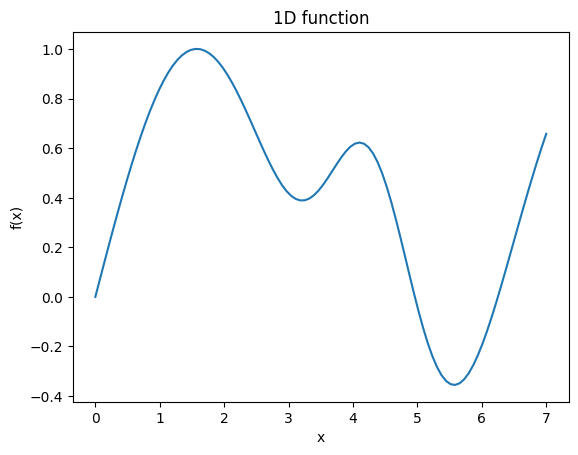

In [ ]:
# Here we define the functional form
def f(X):
    x = X[0, 0]
    y =  np.sin(x) + 1.5*np.exp(-(x - 4.3)**2)
    return y

# Here we define the domain and examine the function
bounds = np.array([[0., 7.]])
fig, ax = plt.subplots()
x = np.linspace(bounds[0, 0], bounds[0, 1], 100)
y_true = np.array([f(np.atleast_2d(xi)) for xi in x])
ax.plot(x, y_true)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('1D function')
plt.show()

## Running BO
The first step in applying BO to a problem is to consider problem dimensionality and the optimization domain, which involves setting the upper and lower bound for each dimension. In BOSS software, this can be set by keywords in an input file, as listed below.

From our problem above, we pass the sampling function and the bounds as an argument. A single entry in the `kernel` array indicates a 1D problem, with an expected `yrange` of approximately [-1; 1]. We begin BO with 2 initial points and acquire 5 more.

Once the BO run is defined, we can execute it using the run function, which produces the the `boss.out` (main output file), `boss.rst` (restart file).

In [ ]:
# Here we define the BO run
bo = BOMain(
    f,
    bounds,
    yrange=[-1, 1],
    kernel='rbf',
    initpts=2,
    iterpts=5,
)

# Here we perform BO
result = bo.run()

To check the quality of the BO, we set up an run the BO postprocessing (PP) routines. The result is the `postprocessing` folder with graphs and raw data.

In [ ]:
pp = PPMain(result, pp_models=True, pp_acq_funcs=True, pp_truef_npts=100)  # add more pp keywords here if needed
pp.run()

## Results and Analysis
Let's visualize the quality of the GP regression fit by checking the results in the `postprocessing` folder. This typically contains:
* a record of data acquisitions (locations and values), with the global minimum predictions
* a set of figures showing the GPR fit at every iteration
* a set of figures showing the GPR acquisition function at every iteration
* global minimum convergence monitoring
* a record of hyperparameter evolution throughout the run.

You can tailor the amount of output data with postprocessing `keywords`.

### 1. Acquisition data check
For the acquired points, let's review the **acquisition locations** (in x, lower graph and y, upper graph), alongside the (x,y) tracking of the **global minimum prediction** (full line).
The key quality check questions to ask are:

* is the sampling distributed across the entire x domain?
* are there any errors in y function evaluation (are the y values distributed across the expected domain)?
* is the predicted global minimum location (full line) converging?


In [ ]:
# Let's inspect the data collection in BOSS
Image(filename = "postprocessing/acquisition_locations.png", width = 500)

### 2. Model refinement check
Let us review the **progression of the model fitting** with 1, 3 and 5 BO acquisitions (execute below) against the true function.<br> The key quality check questions to ask are:

* Is the model converging?
* Has the global minimum been found?
* Is the model uncertainty reducing?
* Has the entire model been converged to the true function?

In [ ]:
# Let's inspect model fitting in BOSS

# figure size in inches optional
rcParams['figure.figsize'] = 18, 14

# read images
it1 = mpimg.imread('postprocessing/graphs_models/it0000_npts0002.png')
it3 = mpimg.imread('postprocessing/graphs_models/it0003_npts0005.png')
it5 = mpimg.imread('postprocessing/graphs_models/it0005_npts0007.png')

# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(it1)
ax[1].imshow(it3)
ax[2].imshow(it5)

### 3. Model convergence check
Let's consider at the **rate of convergence** of the global minimum in both x and y (left image), as well as the **GPR hyperparameter convergence** with BO iterations (right image). The key quality check questions to ask are:

* is the **rate of convergence** reducing on the logarithmic scale?
* has the global minimum been evaluated with a sufficient level of accuracy, given data range?
* are the GPR hyperparameters - GP lengthscale and variance - converging?


In [ ]:
# Let's inspect model convergence in BOSS

# figure size in inches optional
rcParams['figure.figsize'] = 18, 14

# read images
conv = mpimg.imread('postprocessing/convergence_measures.png')
param = mpimg.imread('postprocessing/hyperparameters.png')

# display images
fig, ax = plt.subplots(1,2, frameon=False)
ax[0].imshow(conv)
ax[1].imshow(param)

# Exercise:
Re-define the BOSS run with 20 BO iterations and redo all quality check points. <br> Has the convergence improved? Has the model converged to the true function?

If you start the BO run with more initial points, does the model take fewer points to converge?